# Forex Prediction
In this project, you'll classify the outcome of a series of technichal indicators output by Zorro's NEURAL function. The dimensions (i.e. total indiactors used) will be variable. If possible you'll preprocess the data to try and increase uniformity (indicators can NOT be normalised togethers), then train a convolutional neural network on all the samples. Each sample will be one-hot encoded to a price-change probability distribution. For example:

[+50%, +40%, +30%, +20%, +10%, 0%, -10%, -20%, -30%, -40%, -50%]

Where each entry above is how much the next closing price will change from the previous. A well-trained, well-functioning neural network should output a gaussian distribution of probabilites in the output vector (lack of such a distribution is not a game ender, but should be treated more cautiously).

You'll get to apply what you learned and build a convolutional, max pooling, dropout, and fully connected layers.

In [160]:
from os.path import isfile, isdir

input_file = "data.csv"
assert isfile(input_file)

## Implement Preprocess Functions
### Normalize
In the cell below, implement the `normalize` function to take in tech-indicator data, `x`, and return it as a normalized Numpy array. The values should be in the range of 0 to 1, inclusive.  The return object should be the same shape as `x`.

In [161]:
import numpy as np

def normalize(x, lastColOnly, firstDontChange):
    """
    The first few columns are stand alone and should be normalised only against their
    own column data. For example, day and time.
    The next batch of columns are all in price units, you can't noramise multiple rows
    together here as the a long term trend should look different betwee 2 different rows.
    For example 1,2,3 and later 10,11,13 - the pattern gets distored by making the 
    each end look larger. The middle columns are normalised 1 row at a time.
    The last set of columns contain data that shouldn't be noramlised,
    such as change percetage and bollinger bands (which are already noramlised)
    """
    assert firstDontChange < len(x[0])
    assert lastColOnly < firstDontChange
    
    #normalise each of the first columns
    col_min = x.min(0)
    col_ptp = x.ptp(0)
    for col in range(lastColOnly):
        for row in range(len(x)):
            x[row][col] = (x[row][col] - col_min[col]) / col_ptp[col]
    
    #normalise the middle rows one at a time
    for row in range(len(x)):
        row_min = x[row][lastColOnly]
        row_max = x[row][lastColOnly]
        #find mix and max
        for col in range(lastColOnly+1, firstDontChange):
            curr = x[row][col]
            if(curr < row_min):
                row_min = curr
            if(curr > row_max):
                row_max = curr
        #noramlise the subsection of the row using the found min/max values
        for col in range(lastColOnly, firstDontChange):
            curr = x[row][col]
            x[row][col] = (curr-row_min)/(row_max-row_min)
    return x

assertion_test_data = np.array([[0.0,1,2,3  ,4,5],[5,4,3,2  ,1,0]])
expected =            np.array([[0.0,0,0,0.5,1,5],[1,1,1,0.5,0,0]])
#indexes 0&1 column -wise normalise, 2&3&4 row-wise-norm, 5 - don't change
norm_result = normalize(assertion_test_data, 2, 5) 
assert norm_result.shape == assertion_test_data.shape
assert (norm_result==expected).all()
print("Normalisation assertions pass")

Normalisation assertions pass


### One-hot encode
Just like the previous code cell, you'll be implementing a function for preprocessing.  This time, you'll implement the `one_hot_encode` function. The input, `x`, is a list of change percent sizes - these will be fitted into certain ranges. Make sure to save the map of encodings outside the function.

In [162]:
#https://docs.scipy.org/doc/numpy/reference/generated/numpy.eye.html
#Eye creates a 2d array with only the diagonal valued at 1, then we return the list/encoding at index x

def get_hot_index(change_size, totalSteps, stepSize):
    """
    Given the size of a price change finds the index that corrensponds to it in the encoding scheme.
    totalSteps-> the number of steps to put on both sides of 0
    step_Size-> the granularity of steps. Eg 1% is highly granular, 50% is too broad (unless your prices fluctuate hugely)
    There will always be an equal distribution of values on either side of 0 (in the centre of the encoding)
    eg: -20, -10, 0, 10, 20 
    Values above/below the max/min will encode to those one of those extremes
    Values will conform to the first index less than or equal to the lowest absolute value match
    """
    #centre position
    if(abs(change_size) < stepSize):
        return totalSteps
    #extreme low end
    elif(change_size <= -stepSize * totalSteps):
        return 0
    #extreme high end
    elif(change_size >= stepSize * totalSteps):
        return totalSteps*2
    
    
    centreIndex = totalSteps
    direction = -1 if change_size < 0 else 1
    end = totalSteps+centreIndex if direction == 1 else -1 
    value = 0
    for i in range(centreIndex, end, direction):
        value += stepSize
        if(abs(change_size) < value):
            return i
         
    assert False, "Should be unreachable"
        
assert get_hot_index(0, 1, 5) == 1, "A change of 0 should always return the centre index"
assert get_hot_index(0.1, 2, 5) == 2, "A change smaller than the smallest step size should return the centre"
assert get_hot_index(100, 5, 1) == 10, "Extreme upper bound should be the final possible index"
assert get_hot_index(-7.5, 3, 5) == 2, "-7.5 is less than the smallest step by 1 incremement, so it should be centre-1"
assert get_hot_index(7.5, 3, 5) == 4, "7.5 is 1 more than the smallest step: result==centre+1" 
assert get_hot_index(10, 3, 5) == 5, "10 is on the edge of being 2 steps more than the smallest step" 
assert get_hot_index(-10, 3, 5) == 1, "10 is on the edge of being 2 steps less than the smallest step" 
assert get_hot_index(15, 3, 5) == 6, "10 is on the edge of being 2 steps less than the smallest step" 
assert get_hot_index(1.1, 5, 1) == 6


total_steps = 4
encoding_step_size = 0.1
total_label_count = total_steps+1+total_steps #1 for the centre, and X on either side of it
encodings = np.eye(total_label_count)
#pre-declaring encoding (i.e. outside the method) decreases future work

def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    ret = []
    for elem in x:
        ret.append(encodings[get_hot_index(elem, total_steps, encoding_step_size)])
    return np.array(ret)

temp = np.array([-5*encoding_step_size,-4*encoding_step_size,-3*encoding_step_size,-2*encoding_step_size,-encoding_step_size, 0, encoding_step_size, encoding_step_size*2, encoding_step_size*3, encoding_step_size*4, encoding_step_size*5])
expected = np.array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
                    [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
                    [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
                    [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
                    [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
                    [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
                    [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
                    [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
                    [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
                    [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
                    [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]])

assert (one_hot_encode(temp)==expected).all()
print("One hot encodings pass")

One hot encodings pass


### Randomize Data
As you saw from exploring the data above, the order of the samples are randomized.  It doesn't hurt to randomize it again, but you don't need to for this dataset.

## Preprocess all the data and save it
Running the code cell below will preprocess all the CIFAR-10 data and save it to file. The code below also uses 10% of the training data for validation.

In [163]:
from numpy import genfromtxt

#note that column_only_count will determine one dimension of the reshaped 2d raw data when it gets
#transformed into a list of 2d arrays (for convolutional purposes)
column_only_count = 6
per_row_count = 6
#the x and y dimension will be set when calling preProcessAndShape(). They reprsent the new shape each entry will take
xDim = None
yDim = None

def loadBatchFromFile(inputFile):
    '''Loads raw input from the file into a 2d numpy array'''
    return genfromtxt(inputFile, delimiter=',')
    
def splitIntoFeaturesAndLabels(unchangedInput):
    '''Normalises the raw data, then splits the single output/label column from everything else
    a 2d feature array and 1d label array are returned'''
    normed = normalize(unchangedInput, column_only_count, column_only_count+per_row_count+1)
    #normed is 2d, and need to be split down the centre
    return normed[:,:-1], normed[:,-1]

def preProcessAndShape(inputFile):
    '''Input file is read, normalised, reshaped and labels are transformed before both
    features and labels are returned'''
    raw = loadBatchFromFile(inputFile)
    features, labels = splitIntoFeaturesAndLabels(raw)
    
    global xDim, yDim
    xDim = len(features[0]) // column_only_count
    yDim = len(features[0]) // xDim
    
    #the extra size 1 dimension is so that convolutions can create deeper dimensions
    return features.reshape((len(features),xDim,yDim,1)), one_hot_encode(labels)

# Check Point
This is your first checkpoint.  If you ever decide to come back to this notebook or have to restart the notebook, you can start from here.  The preprocessed data has been saved to disk.

In [164]:
import pickle
import helper

## Load the Preprocessed Validation data
##valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))
#pre-process the data, ensure that the feature and label dimensions match
valid_features, valid_labels = preProcessAndShape(input_file)

assert valid_features.shape[0] == valid_labels.shape[0], "The features and labels should be of equal length"
print("Pre-processing successful")

Pre-processing successful


## Build the network
For the neural network, you'll build each layer into a function.  Most of the code you've seen has been outside of functions. To test your code more thoroughly, we require that you put each layer in a function.  This allows us to give you better feedback and test for simple mistakes using our unittests before you submit your project.

>**Note:** If you're finding it hard to dedicate enough time for this course each week, we've provided a small shortcut to this part of the project. In the next couple of problems, you'll have the option to use classes from the [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) packages to build each layer, except the layers you build in the "Convolutional and Max Pooling Layer" section.  TF Layers is similar to Keras's and TFLearn's abstraction to layers, so it's easy to pickup.

>However, if you would like to get the most out of this course, try to solve all the problems _without_ using anything from the TF Layers packages. You **can** still use classes from other packages that happen to have the same name as ones you find in TF Layers! For example, instead of using the TF Layers version of the `conv2d` class, [tf.layers.conv2d](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d), you would want to use the TF Neural Network version of `conv2d`, [tf.nn.conv2d](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d). 

Let's begin!

### Input
The neural network needs to read the image data, one-hot encoded labels, and dropout keep probability. Implement the following functions
* Implement `neural_net_image_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder)
 * Set the shape using `image_shape` with batch size set to `None`.
 * Name the TensorFlow placeholder "x" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).
* Implement `neural_net_label_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder)
 * Set the shape using `n_classes` with batch size set to `None`.
 * Name the TensorFlow placeholder "y" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).
* Implement `neural_net_keep_prob_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder) for dropout keep probability.
 * Name the TensorFlow placeholder "keep_prob" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).

These names will be used at the end of the project to load your saved model.

Note: `None` for shapes in TensorFlow allow for a dynamic size.

In [198]:
import tensorflow as tf

def neural_net_image_input(image_shape):
    """
    Return a Tensor for a bach of image input
    : image_shape: Shape of the images
    : return: Tensor for image input.
    """
    return tf.placeholder(tf.float32, shape=(None, *image_shape), name='x')
    #return tf.placeholder(tf.float32, shape=(None,Image_shape[0],image_shape[1],image_shape[2]), name='x')


def neural_net_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    : return: Tensor for label input.
    """
    print("n_classes",n_classes)
    return tf.placeholder(tf.float32, shape=(None,n_classes), name='y')


def neural_net_keep_prob_input():
    """
    Return a Tensor for keep probability
    : return: Tensor for keep probability.
    """
    return tf.placeholder(tf.float32, name='keep_prob')

#
#"""
#DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
#"""
#tf.reset_default_graph()
#tests.test_nn_image_inputs(neural_net_image_input)
#tests.test_nn_label_inputs(neural_net_label_input)
#tests.test_nn_keep_prob_inputs(neural_net_keep_prob_input)

### Convolution and Max Pooling Layer
Convolution layers have a lot of success with images. For this code cell, you should implement the function `conv2d_maxpool` to apply convolution then max pooling:
* Create the weight and bias using `conv_ksize`, `conv_num_outputs` and the shape of `x_tensor`.
* Apply a convolution to `x_tensor` using weight and `conv_strides`.
 * We recommend you use same padding, but you're welcome to use any padding.
* Add bias
* Add a nonlinear activation to the convolution.
* Apply Max Pooling using `pool_ksize` and `pool_strides`.
 * We recommend you use same padding, but you're welcome to use any padding.

**Note:** You **can't** use [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) for **this** layer, but you can still use TensorFlow's [Neural Network](https://www.tensorflow.org/api_docs/python/tf/nn) package. You may still use the shortcut option for all the **other** layers.

In [199]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    #color_channels = int(x_tensor.shape[3])
    depth = int(x_tensor.shape[3])
    print("depth",depth)
    print("x_tensor", x_tensor)
    
    # Weight and bias                        filter height,  filter width ,                ,k_output
    #weight = tf.Variable(tf.truncated_normal([conv_ksize[0], conv_ksize[1], color_channels, conv_num_outputs]))
    #! @TUTOR/REVIEWER: why does the above weight generation technique devolve to 10% acurracy on the same architecture,
    #! but the one below performs really well? The above method was the one showed to us in lessons...
    weight = tf.Variable(tf.random_normal([conv_ksize[0], conv_ksize[1], depth,  conv_num_outputs], stddev=0.1))
    print("weight", weight)
    bias = tf.Variable(tf.zeros(conv_num_outputs))
    print("bias", bias)
    # Apply Convolution
    conv_layer = tf.nn.conv2d(x_tensor, weight, strides=[1, conv_strides[0], conv_strides[1], 1], padding='VALID')
    print("1", conv_layer)
    # Add bias
    conv_layer = tf.nn.bias_add(conv_layer, bias)
    print("2", conv_layer)
    # Apply activation function
    conv_layer = tf.nn.relu(conv_layer)
    print("3", conv_layer)
    
    # Apply Max Pooling
    conv_layer = tf.nn.max_pool(
                        conv_layer,
                        ksize=[1, pool_ksize[0], pool_ksize[1], 1],
                        strides=[1, pool_strides[0], pool_strides[1], 1],
                        padding='VALID')
    print("4", conv_layer)
    return conv_layer 



### Flatten Layer
Implement the `flatten` function to change the dimension of `x_tensor` from a 4-D tensor to a 2-D tensor.  The output should be the shape (*Batch Size*, *Flattened Image Size*). Shortcut option: you can use classes from the [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) packages for this layer. For more of a challenge, only use other TensorFlow packages.

In [218]:
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    sizes = x_tensor.get_shape().as_list()
    #sizes[0] is batch size. 1,2, and 3 are convolved dimensions
    return tf.reshape(x_tensor, [-1, sizes[1]*sizes[2]*sizes[3]])

### Fully-Connected Layer
Implement the `fully_conn` function to apply a fully connected layer to `x_tensor` with the shape (*Batch Size*, *num_outputs*). Shortcut option: you can use classes from the [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) packages for this layer. For more of a challenge, only use other TensorFlow packages.

In [219]:
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    w_shape = (int(x_tensor.get_shape().as_list()[1]), num_outputs)
    sizes = x_tensor.get_shape().as_list()

    #weight = tf.Variable(tf.truncated_normal((int(sizes[1]), num_outputs)))
    #! @TUTOR/REVIEWER: why does the above weight generation technique devolve to 10% acurracy on the same architecture,
    #! but the one below performs really well? The above method was the one showed to us in lessons...
    weight = tf.Variable(tf.random_normal((int(sizes[1]), num_outputs), stddev=0.1))
    bias = tf.Variable(tf.zeros(num_outputs))
    
    fc = tf.add(tf.matmul(x_tensor, weight), bias)
    fc = tf.nn.relu(fc)
    
    return fc

### Output Layer
Implement the `output` function to apply a fully connected layer to `x_tensor` with the shape (*Batch Size*, *num_outputs*). Shortcut option: you can use classes from the [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) packages for this layer. For more of a challenge, only use other TensorFlow packages.

**Note:** Activation, softmax, or cross entropy should **not** be applied to this.

In [220]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    sizes = x_tensor.get_shape().as_list()
    print("Sizes:",sizes)
    #weight = tf.Variable(tf.truncated_normal([int(sizes[1]), num_outputs]))
    #! @TUTOR/REVIEWER: why does the above weight generation technique devolve to 10% acurracy on the same architecture,
    #! but the one below performs really well? The above method was the one showed to us in lessons...
    weight = tf.Variable(tf.random_normal([int(sizes[1]), num_outputs], stddev=0.1))
    bias = tf.Variable(tf.zeros(num_outputs))
    
    fc = tf.add(tf.matmul(x_tensor, weight), bias)
    print(fc)
    
    return fc

### Create Convolutional Model
Implement the function `conv_net` to create a convolutional neural network model. The function takes in a batch of images, `x`, and outputs logits.  Use the layers you created above to create this model:

* Apply 1, 2, or 3 Convolution and Max Pool layers
* Apply a Flatten Layer
* Apply 1, 2, or 3 Fully Connected Layers
* Apply an Output Layer
* Return the output
* Apply [TensorFlow's Dropout](https://www.tensorflow.org/api_docs/python/tf/nn/dropout) to one or more layers in the model using `keep_prob`. 

In [221]:
def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    #    conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides)
    print("input x:", x)
    x = conv2d_maxpool(x, 30, (2, 2), (1, 1), (1, 1), (1, 1))
    print("Conv 1: ",x)
    #x = conv2d_maxpool(x, 30, (1, 1), (1, 1), (2, 2), (2, 2))
    #print("Conv 2: " + str(x.get_shape().as_list()))
    #x = conv2d_maxpool(x, 70, (4, 4), (2, 2), (2, 2), (2, 2))
    #print("Conv 3: " + str(x.get_shape().as_list()))

    # Apply a Flatten Layer
    x = flatten(x)
    print("Flattened : " ,x)
    

    # TODO: Apply 1, 2, or 3 Fully Connected Layers
    #    Play around with different number of outputs
    # Function Definition from Above:
    #   fully_conn(x_tensor, num_outputs)
    x = fully_conn(x, 80)
    print("FC 1 : " + str(x.get_shape().as_list()))
    x = tf.nn.dropout(x, keep_prob)
    x = fully_conn(x, 40)
    print("FC 2 : " + str(x.get_shape().as_list()))
    x = tf.nn.dropout(x, keep_prob)
    
    # TODO: Apply an Output Layer
    #    Set this to the number of classes
    # Function Definition from Above:
    #   output(x_tensor, num_outputs)
    out = output(x, total_label_count) #total label counts comes from near one_hot_encode where the category count is determined
    
    
    # TODO: return output
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

##############################
## Build the Neural Network ##
##############################


# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((xDim,yDim,1))
print(x)
y = neural_net_label_input(total_label_count) #total_label_count is detemined up near one_hot_encode, it is the total number of categories
keep_prob = neural_net_keep_prob_input()
print("label",y)

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

print("logits: ",logits)

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

#tests.test_conv_net(conv_net)

Tensor("x:0", shape=(?, 4, 6, 1), dtype=float32)
n_classes 9
label Tensor("y:0", shape=(?, 9), dtype=float32)
input x: Tensor("x:0", shape=(?, 4, 6, 1), dtype=float32)
depth 1
x_tensor Tensor("x:0", shape=(?, 4, 6, 1), dtype=float32)
weight Tensor("Variable/read:0", shape=(2, 2, 1, 30), dtype=float32)
bias Tensor("Variable_1/read:0", shape=(30,), dtype=float32)
1 Tensor("Conv2D:0", shape=(?, 3, 5, 30), dtype=float32)
2 Tensor("BiasAdd:0", shape=(?, 3, 5, 30), dtype=float32)
3 Tensor("Relu:0", shape=(?, 3, 5, 30), dtype=float32)
4 Tensor("MaxPool:0", shape=(?, 3, 5, 30), dtype=float32)
Conv 1:  Tensor("MaxPool:0", shape=(?, 3, 5, 30), dtype=float32)
Flattened :  Tensor("Reshape:0", shape=(?, 450), dtype=float32)
FC 1 : [None, 80]
FC 2 : [None, 40]
Sizes: [None, 40]
Tensor("Add_2:0", shape=(?, 9), dtype=float32)
logits:  Tensor("logits:0", shape=(?, 9), dtype=float32)


## Train the Neural Network
### Single Optimization
Implement the function `train_neural_network` to do a single optimization.  The optimization should use `optimizer` to optimize in `session` with a `feed_dict` of the following:
* `x` for image input
* `y` for labels
* `keep_prob` for keep probability for dropout

This function will be called for each batch, so `tf.global_variables_initializer()` has already been called.

Note: Nothing needs to be returned. This function is only optimizing the neural network.

In [222]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    session.run(optimizer, feed_dict={
                        x: feature_batch,
                        y: label_batch,
                        keep_prob: keep_probability})


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
#tests.test_train_nn(train_neural_network)

"\nDON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE\n"

### Show Stats
Implement the function `print_stats` to print loss and validation accuracy.  Use the global variables `valid_features` and `valid_labels` to calculate validation accuracy.  Use a keep probability of `1.0` to calculate the loss and validation accuracy.

In [223]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    loss = sess.run(cost, feed_dict={
                x: feature_batch,
                y: label_batch,
                keep_prob: 1.})
    valid_acc = sess.run(accuracy, feed_dict={
                x: valid_features,
                y: valid_labels,
                keep_prob: 1.})
    print('Loss: {:>10.4f} Validation Accuracy: {:.6f} L/V: {:.6f}'.format(loss, valid_acc, loss/valid_acc))

### Hyperparameters
Tune the following parameters:
* Set `epochs` to the number of iterations until the network stops learning or start overfitting
* Set `batch_size` to the highest number that your machine has memory for.  Most people set them to common sizes of memory:
 * 64
 * 128
 * 256
 * ...
* Set `keep_probability` to the probability of keeping a node using dropout

In [230]:
# TODO: Tune Parameters
epochs = 200
batch_size = 256
keep_probability = .5

### Train on a Single CIFAR-10 Batch
Instead of training the neural network on all the CIFAR-10 batches of data, let's use a single batch. This should save time while you iterate on the model to get a better accuracy.  Once the final validation accuracy is 50% or greater, run the model on all the data in the next section.

In [231]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
print('Checking the Training on a Single Batch...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        batch_i = 1
        #for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
        print(valid_features.shape)
        train_neural_network(sess, optimizer, keep_probability, valid_features, valid_labels)
        
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_stats(sess, valid_features, valid_labels, cost, accuracy)

Checking the Training on a Single Batch...
(42, 4, 6, 1)
Epoch  1, CIFAR-10 Batch 1:  Loss:     2.1771 Validation Accuracy: 0.000000 L/V: inf
(42, 4, 6, 1)
Epoch  2, CIFAR-10 Batch 1:  Loss:     2.1445 Validation Accuracy: 0.476190 L/V: 4.503463
(42, 4, 6, 1)
Epoch  3, CIFAR-10 Batch 1:  Loss:     2.1155 Validation Accuracy: 0.452381 L/V: 4.676311
(42, 4, 6, 1)
Epoch  4, CIFAR-10 Batch 1:  Loss:     2.0897 Validation Accuracy: 0.452381 L/V: 4.619240
(42, 4, 6, 1)
Epoch  5, CIFAR-10 Batch 1:  Loss:     2.0647 Validation Accuracy: 0.452381 L/V: 4.564112
(42, 4, 6, 1)
Epoch  6, CIFAR-10 Batch 1:  Loss:     2.0397 Validation Accuracy: 0.452381 L/V: 4.508805
(42, 4, 6, 1)
Epoch  7, CIFAR-10 Batch 1:  Loss:     2.0136 Validation Accuracy: 0.452381 L/V: 4.451146
(42, 4, 6, 1)
Epoch  8, CIFAR-10 Batch 1:  Loss:     1.9847 Validation Accuracy: 0.452381 L/V: 4.387221
(42, 4, 6, 1)
Epoch  9, CIFAR-10 Batch 1:  Loss:     1.9535 Validation Accuracy: 0.452381 L/V: 4.318359
(42, 4, 6, 1)
Epoch 10, CI

C:\Users\Matthew\Miniconda3\envs\TF35\lib\site-packages\ipykernel\__main__.py:18: RuntimeWarning: divide by zero encountered in float_scalars


Loss:     1.5668 Validation Accuracy: 0.452381 L/V: 3.463382
(42, 4, 6, 1)
Epoch 19, CIFAR-10 Batch 1:  Loss:     1.5117 Validation Accuracy: 0.452381 L/V: 3.341738
(42, 4, 6, 1)
Epoch 20, CIFAR-10 Batch 1:  Loss:     1.4566 Validation Accuracy: 0.452381 L/V: 3.219895
(42, 4, 6, 1)
Epoch 21, CIFAR-10 Batch 1:  Loss:     1.4019 Validation Accuracy: 0.452381 L/V: 3.098855
(42, 4, 6, 1)
Epoch 22, CIFAR-10 Batch 1:  Loss:     1.3472 Validation Accuracy: 0.452381 L/V: 2.978117
(42, 4, 6, 1)
Epoch 23, CIFAR-10 Batch 1:  Loss:     1.2947 Validation Accuracy: 0.452381 L/V: 2.861888
(42, 4, 6, 1)
Epoch 24, CIFAR-10 Batch 1:  Loss:     1.2448 Validation Accuracy: 0.452381 L/V: 2.751575
(42, 4, 6, 1)
Epoch 25, CIFAR-10 Batch 1:  Loss:     1.1989 Validation Accuracy: 0.452381 L/V: 2.650121
(42, 4, 6, 1)
Epoch 26, CIFAR-10 Batch 1:  Loss:     1.1577 Validation Accuracy: 0.452381 L/V: 2.559171
(42, 4, 6, 1)
Epoch 27, CIFAR-10 Batch 1:  Loss:     1.1226 Validation Accuracy: 0.452381 L/V: 2.481518
(42

### Fully Train the Model
Now that you got a good accuracy with a single CIFAR-10 batch, try it with all five batches.

In [90]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...


FileNotFoundError: [Errno 2] No such file or directory: 'preprocess_batch_1.p'

# Checkpoint
The model has been saved to disk.
## Test Model
Test your model against the test dataset.  This will be your final accuracy. You should have an accuracy greater than 50%. If you don't, keep tweaking the model architecture and parameters.

Testing Accuracy: 0.57734375



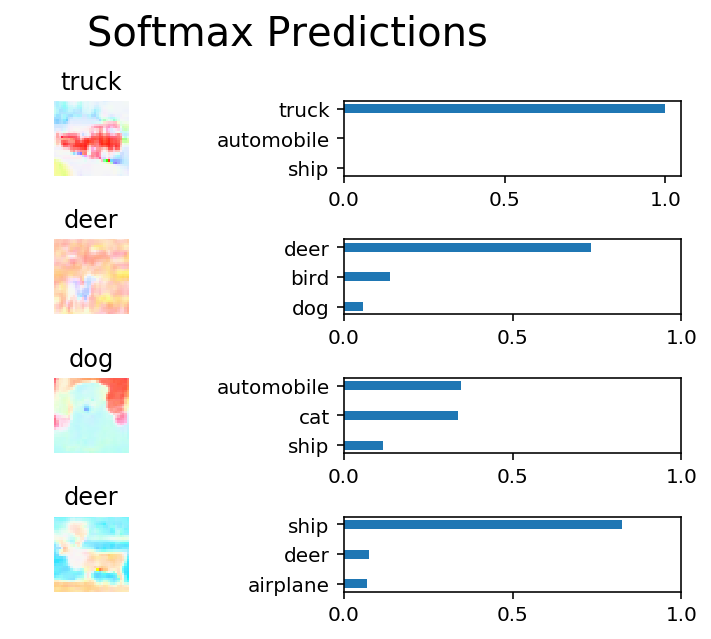

In [28]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import helper
import random

# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """

    test_features, test_labels = pickle.load(open('preprocess_training.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for train_feature_batch, train_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: train_feature_batch, loaded_y: train_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()

##################
#! @TUTOR/REVIEWER: why are the images generated below so distored when compared to those being posted on Slack?
#! I trained this network on my Windows machine... is there any change there are OS specific idiosyncracies in some of the libraries?
##################

## Why 50-70% Accuracy?
You might be wondering why you can't get an accuracy any higher. First things first, 50% isn't bad for a simple CNN.  Pure guessing would get you 10% accuracy. However, you might notice people are getting scores [well above 70%](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d3130).  That's because we haven't taught you all there is to know about neural networks. We still need to cover a few more techniques.
## Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook.  Save the notebook file as "dlnd_image_classification.ipynb" and save it as a HTML file under "File" -> "Download as".  Include the "helper.py" and "problem_unittests.py" files in your submission.